<a href="https://colab.research.google.com/github/Leo-Lifeblood/Projects/blob/main/Distributional_DQN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 19.4 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical, Cauchy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
!pip uninstall -y box2d-py
!pip install gymnasium pygame swig
!pip install box2d-py==2.3.5 --no-cache-dir --force-reinstall
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376134 sha256=e2d85c36eefcd8e82b961b3c8adfc6c8f3c0ea136f98c1e48ae177c3788827a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-8h2wk583/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
env = gym.make("LunarLander-v3")

In [ ]:
class FFN(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    self.norm = nn.LayerNorm(hidden_dim)
    self.dense1 = nn.LazyLinear(hidden_dim*4)
    self.relu = nn.ReLU()
    self.dense2 = nn.LazyLinear(hidden_dim)

  def forward(self, x):
    x2 = self.norm(x)
    x2 = self.dense1(x2)
    x2 = self.relu(x2)
    x2 = self.dense2(x2)
    x = x + x2
    return x

class DistributionalDuelingDQN(nn.Module):
  def __init__(self, action_dim, hidden_dim, num_layers, num_accumulation_steps=4, target_update_frequency=5, tau=0.90):
    super().__init__()

    self.action_dim = action_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.tau = tau

    self.num_accumulation_steps = num_accumulation_steps
    self.accumulation_step = 0

    self.target_update_frequency = target_update_frequency*num_accumulation_steps
    self.target_update_counter = 0
    self.target_network = None


    self.initial_layer = nn.LazyLinear(hidden_dim)



    self.layers = nn.ModuleList([FFN(hidden_dim) for _ in range(num_layers)])



    self.V = nn.LazyLinear(1)
    self.A = nn.LazyLinear(action_dim)

    self.Sigma_Q = nn.LazyLinear(action_dim)





  def forward(self, x):

    x = self.initial_layer(x)


    for layer in self.layers:
      x = layer(x)



    V = self.V(x)
    A = self.A(x)

    Q_Mu = V + (A - A.mean(dim=1, keepdim=True))
    #Q_Sigma = F.softplus(self.Sigma_Q(x))+0.001
    #Q_Sigma = torch.abs(V) * (F.tanh(self.Sigma_Q(x))+1.101)
    Q_Sigma = F.softplus(self.Sigma_Q(x))+1

    return Q_Mu, Q_Sigma

  def make_target_network(self):
    if self.target_network is None:
      self.target_network = DistributionalDuelingDQN(self.action_dim, self.hidden_dim, self.num_layers, num_accumulation_steps=self.num_accumulation_steps, target_update_frequency=self.target_update_frequency)
      filtered_state_dict = {k: v for k, v in self.state_dict().items() if not k.startswith('target_network') and not k in ['accumulation_step', 'target_update_counter']}
      self.target_network.load_state_dict(filtered_state_dict)
      #print("made_target")

  def update_target_network(self):
    filtered_state_dict = {k: v for k, v in self.state_dict().items() if not k.startswith('target_network') and not k in ['accumulation_step', 'target_update_counter']}
    target_state_dict = self.target_network.state_dict()
    for key in filtered_state_dict.keys():
      target_state_dict[key] = (target_state_dict[key]*self.tau) + (filtered_state_dict[key]*(1-self.tau))
    self.target_network.load_state_dict(target_state_dict)
    #print("updated")


  def training_step(self, batch, optimizer, gamma):
    states, actions, rewards, next_states, dones = batch

    # Forward pass to get current Q-values
    #with torch.no_grad(): # this doesnt work either
    Qprior_mu, Qprior_sigma = self.forward(states)

    actions = actions.unsqueeze(-1)
    Qprior_mu = Qprior_mu.gather(1, actions).squeeze(-1)
    Qprior_sigma = Qprior_sigma.gather(1, actions).squeeze(-1)


    with torch.no_grad():
      self.make_target_network()
      next_Q_mu, next_Q_sigma = self.target_network(next_states)
      max_next_Q_mu_values,  max_next_Q_mu_indices= torch.max(next_Q_mu, dim=-1)
      max_next_Q_sigma = next_Q_sigma.gather(1, max_next_Q_mu_indices.unsqueeze(-1)).squeeze(-1)

      max_next_Q_mu_values = max_next_Q_mu_values * (1 - dones) * gamma



    td_error_mu = Qprior_mu - max_next_Q_mu_values
    td_error_sigma = torch.sqrt(torch.square(Qprior_sigma) + torch.square(max_next_Q_sigma))
    td_error_sigma = torch.clamp(td_error_sigma, min=1e-3)


    loss = -Normal(td_error_mu, td_error_sigma).log_prob(rewards)

    #loss = torch.clamp_max(loss, 10)
    #if loss.max() > 10:
    #  print(loss.max())
    loss = loss.mean()


    if self.accumulation_step == 0:
      optimizer.zero_grad()

    loss.backward()
    self.accumulation_step += 1
    self.target_update_counter += 1


    if self.target_update_counter >= self.target_update_frequency:
      self.update_target_network()
      self.target_update_counter = 0

    if self.accumulation_step >= self.num_accumulation_steps:
      torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.001)
      optimizer.step()
      self.accumulation_step = 0



    return loss.item()


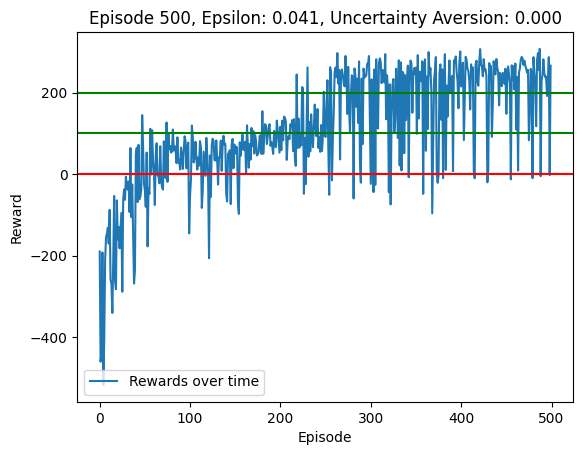

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Initialize CartPole environment
#env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v3")

cutoff = 500#250 # time cutoff
step_frequency = 5

# Hyperparameters
gamma = 0.99
learning_rate = 3e-4#1e-3
batch_size = 256
#batch_size = 64
epsilon = 0.5#1  # Initial epsilon for exploration # an epsilon starting at 1 will converge with a decay of 0.995
epsilon_decay = 0.995#0.995  # Decay rate for epsilon # 0.995 with an epsilon starting at 1 will converge
epsilon_min = 0.01
#memory_size = 10000
memory_size = 100000
num_episodes = 500
hidden_dim = 128
accumulation_steps = 4
num_layers = 2
model_confidence = 0.0

risk_decay = 0.997#0.980


# Initialize model, optimizer, and replay buffer
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = DistributionalDuelingDQN(action_dim, hidden_dim, num_layers, num_accumulation_steps = accumulation_steps)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

class EWMA:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.value = None

    def update(self, new_value):
        if self.value is None:
            self.value = new_value
        else:
            self.value = self.alpha * new_value + (1 - self.alpha) * self.value

    def get_value(self):
        return self.value if self.value is not None else 0.0


mean_uncertainty = EWMA()

"""
# Function to choose an action based on epsilon-greedy policy
def select_action(state, epsilon, return_sigma=False):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            Q_mu, Q_sigma = model(state)
            mean_uncertainty.update(Q_sigma.mean().item())
            uncertainty_percent = Q_sigma/mean_uncertainty.get_value()
            #print(variation_coefficient)
        return Q_mu.argmax(dim=1).item()
        #return Q_sigma.argmax(dim=1).item()
        #return (Q_mu-(Q_sigma/Q_mu)).argmax(dim=1).item()
"""
"""
def select_action(state, epsilon, return_figures=False):
    if random.random() < epsilon:
        return env.action_space.sample(), 0, 0
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            Q_mu, Q_sigma = model(state)
            mean_uncertainty.update(Q_sigma.mean().item())
            uncertainty_percent = Q_sigma / mean_uncertainty.get_value()

            selected_action = Q_mu.argmax(dim=1).item()
            selected_uncertainty = uncertainty_percent[0, selected_action].item()  # Uncertainty for the selected action
            selected_q = Q_mu[0, selected_action].item()

        if return_figures:
            return selected_action, selected_uncertainty, selected_q
        else:
            return selected_action
"""
def select_action(state, epsilon, model_confidence=0.0, return_figures=False):
    if random.random() < epsilon:
      if return_figures:
        return env.action_space.sample(), 0, 0
      else:
        return env.action_space.sample()

    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            Q_mu, Q_sigma = model(state)
            mean_uncertainty.update(Q_sigma.mean().item())
            uncertainty_percent = Q_sigma / mean_uncertainty.get_value()


            Uncertainty_Adjusted = (Q_sigma/Q_sigma.mean(dim=-1, keepdim=True))*Q_mu.mean(dim=-1, keepdim=True)


            Mu_adjusted = Q_mu+(Q_sigma*model_confidence)


            #selected_action = Q_mu.argmax(dim=1).item()
            selected_action = Mu_adjusted.argmax(dim=1).item()
            selected_uncertainty = Q_sigma[0, selected_action].item()
            selected_q = Q_mu[0, selected_action].item()

        if return_figures:
            return selected_action, selected_uncertainty, selected_q
        else:
            return selected_action


def sample_batch(batch_size):
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)
    return states, actions, rewards, next_states, dones

rewards = []



for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    time = 0

    while (not done) and (time < cutoff):
        time += 1
        action = select_action(state, epsilon, model_confidence=model_confidence)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if (len(memory) >= batch_size)&(time%step_frequency==0):
            batch = sample_batch(batch_size)
            loss = model.training_step(batch, optimizer, gamma)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    model_confidence *= risk_decay

    rewards.append(total_reward)




    plt.plot(rewards, label = "Rewards over time")
    plt.axhline(y = 0.0, color = 'r', linestyle = '-')
    plt.axhline(y = 100.0, color = 'g', linestyle = '-')
    plt.axhline(y = 200.0, color = 'g', linestyle = '-')
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    plt.title(f"Episode {episode + 1}, Epsilon: {epsilon:.3f}, Uncertainty Aversion: {model_confidence:.3f}")
    plt.legend(loc=3)
    plt.show()
    clear_output(wait=True)

env.close()

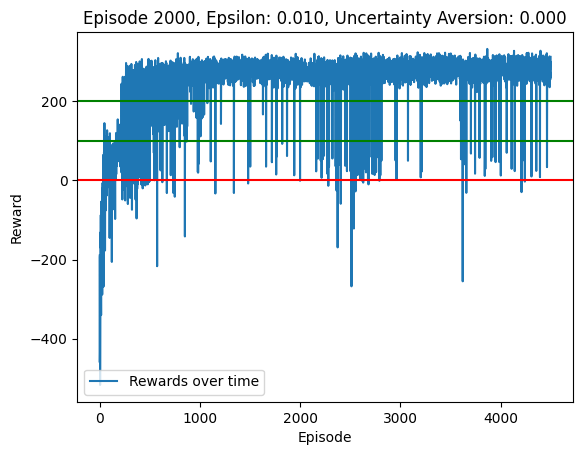

In [ ]:
epsilon = 0.15
num_episodes = 2000
#risk_decay = 0.995
#env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v3")

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    time = 0

    while (not done) and (time < cutoff):
        time += 1
        action = select_action(state, epsilon, model_confidence=model_confidence)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if (len(memory) >= batch_size)&(time%step_frequency==0):
            batch = sample_batch(batch_size)
            loss = model.training_step(batch, optimizer, gamma)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    model_confidence *= risk_decay

    rewards.append(total_reward)


    plt.plot(rewards, label = "Rewards over time")
    plt.axhline(y = 0.0, color = 'r', linestyle = '-')
    plt.axhline(y = 100.0, color = 'g', linestyle = '-')
    plt.axhline(y = 200.0, color = 'g', linestyle = '-')
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    plt.title(f"Episode {episode + 1}, Epsilon: {epsilon:.3f}, Uncertainty Aversion: {model_confidence:.3f}")
    plt.legend(loc=3)
    plt.show()
    clear_output(wait=True)
    #print(mean_uncertainty.get_value())

env.close()

In [ ]:
def select_action(state, epsilon, model_confidence=0.0, return_figures=False):
    if random.random() < epsilon:
      if return_figures:
        return env.action_space.sample(), 0, 0
      else:
        return env.action_space.sample()

    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            Q_mu, Q_sigma = model(state)
            mean_uncertainty.update(Q_sigma.mean().item())
            uncertainty_percent = Q_sigma / mean_uncertainty.get_value()


            Uncertainty_Adjusted = (Q_sigma/Q_sigma.mean(dim=-1, keepdim=True))*Q_mu.mean(dim=-1, keepdim=True)


            Mu_adjusted = Q_mu+(Q_sigma*model_confidence)


            #selected_action = Q_mu.argmax(dim=1).item()
            selected_action = Mu_adjusted.argmax(dim=1).item()
            selected_uncertainty = Q_sigma[0, selected_action].item()
            selected_q = Q_mu[0, selected_action].item()

        if return_figures:
            return selected_action, selected_uncertainty, selected_q
        else:
            return selected_action

In [ ]:
import matplotlib.pyplot as plt
import base64
import io
from IPython.display import HTML
from IPython import display
import os


def visualize_episode(env, epsilon=0.0, use_confidence=0.0, normalize_q_values=True):


  def show_video(filename):
      video = io.open(filename, 'r+b').read()
      encoded = base64.b64encode(video)
      display.display(HTML(data='''
          <video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
          </video>
      '''.format(encoded.decode('ascii'))))


  from gymnasium.wrappers import RecordVideo


  env = RecordVideo(gym.make(env, render_mode="rgb_array"), video_folder="./", name_prefix="cartpole-video")

  state, _ = env.reset()
  done = False
  uncertainties = []
  q_values = []
  rewards = 0
  while not done:
      action, uncertainty, q_value = select_action(state, epsilon, model_confidence=use_confidence, return_figures=True)
      uncertainties.append(uncertainty)
      q_values.append(q_value)
      next_state, reward, terminated, truncated, _ = env.step(action)
      rewards += reward
      done = terminated or truncated
      state = next_state

  env.close()

  import time
  while not any(fname.endswith('.mp4') for fname in os.listdir('./')):
      time.sleep(1)


  uncertainties = np.array(uncertainties)
  q_values = np.array(q_values)

  uncertainties = np.convolve(uncertainties, np.ones(10)/10, mode='valid')
  q_values = np.convolve(q_values, np.ones(10)/10, mode='valid')

  uncertainties = (uncertainties-uncertainties.min())/(uncertainties.max()-uncertainties.min())
  if normalize_q_values: q_values = (q_values-q_values.min())/(q_values.max()-q_values.min())




  plt.plot(uncertainties, label = "Uncertainty over time")
  plt.plot(q_values, label = "Q-value over time") #(the mean is pretty much random)
  plt.title(f"Uncertainty and Q-values over time - Reward {rewards}")
  plt.xlabel("Time step")
  plt.ylabel("Value")
  plt.legend(loc=6)
  plt.show()

  show_video("/content/cartpole-video-episode-0.mp4")

  return rewards

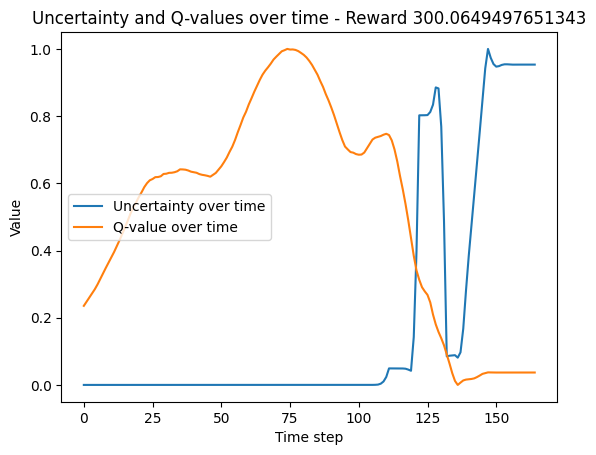

300.0649497651343

In [ ]:
visualize_episode("LunarLander-v3", 0.0, use_confidence=-0.0)

In [ ]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return {"mean": m.round(3), "lower bound": (m-h).round(3), "upper bound": (m+h).round(3)}

In [ ]:
def run_episode(env, epsilon=0.0, use_confidence=0.0):
  env = gym.make(env, render_mode="rgb_array")
  time = 0
  state, _ = env.reset()
  done = False
  uncertainties = []
  q_values = []
  rewards = 0
  while (not done) and (time < cutoff):
      time += 1
      action, uncertainty, q_value = select_action(state, epsilon, model_confidence=use_confidence, return_figures=True)
      uncertainties.append(uncertainty)
      q_values.append(q_value)
      next_state, reward, terminated, truncated, _ = env.step(action)
      rewards += reward
      done = terminated or truncated
      state = next_state

  env.close()

  return rewards


In [ ]:
risk_taking = [run_episode("LunarLander-v3", 0.0, use_confidence=0.2) for _ in range(100)]
normal = [run_episode("LunarLander-v3", 0.0, use_confidence=0.0) for _ in range(100)]
cautious = [run_episode("LunarLander-v3", 0.0, use_confidence=-0.2) for _ in range(100)]

In [ ]:
risk_taking.extend([run_episode("LunarLander-v3", 0.0, use_confidence=0.2) for _ in range(100)])
normal.extend([run_episode("LunarLander-v3", 0.0, use_confidence=0.0) for _ in range(100)])
cautious.extend([run_episode("LunarLander-v3", 0.0, use_confidence=-0.2) for _ in range(100)])

In [ ]:
print(f"Risk taking confidence interval: {mean_confidence_interval(risk_taking)}, \nNormal confidence interval: {mean_confidence_interval(normal)}, \nCautious confidence interval: {mean_confidence_interval(cautious)}")

Risk taking confidence interval: {'mean': 244.475, 'lower bound': 232.877, 'upper bound': 256.073}, 
Normal confidence interval: {'mean': 265.1, 'lower bound': 254.877, 'upper bound': 275.323}, 
Cautious confidence interval: {'mean': 241.284, 'lower bound': 229.18, 'upper bound': 253.388}


In [ ]:
np_risk = np.array(risk_taking)
np_normal = np.array(normal)
np_cautious = np.array(cautious)

print(f"Risk descriptives - mean: {np.mean(np_risk).round(3)} std: {np.std(np_risk).round(3)}, \nNormal descriptives - mean: {np.mean(normal).round(3)} std: {np.std(normal).round(3)}, \nCautious descriptives - mean: {np.mean(cautious).round(3)} std: {np.std(cautious).round(3)}")

Risk descriptives - mean: 244.475 std: 58.158, 
Normal descriptives - mean: 265.1 std: 51.264, 
Cautious descriptives - mean: 241.284 std: 60.696


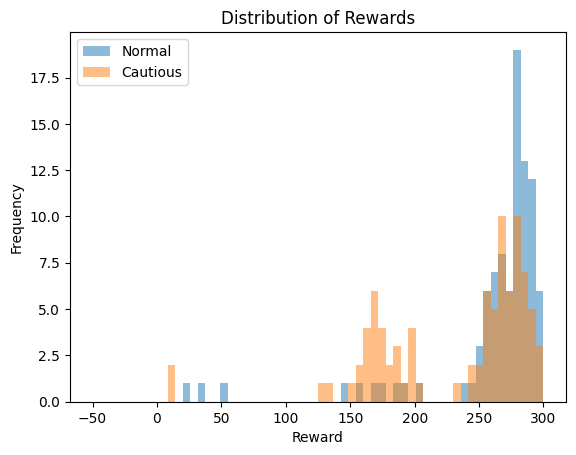

In [ ]:

bins = 60
reward_range = (-50, 300)


#plt.hist(np_risk, bins=bins, range=reward_range, label="Risk taking", alpha=0.5)
plt.hist(np_normal, bins=bins, range=reward_range, label="Normal", alpha=0.5)
plt.hist(np_cautious, bins=bins, range=reward_range, label="Cautious", alpha=0.5)


plt.title("Distribution of Rewards")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Confidence Sweep:   0%|          | 0/20 [00:00<?, ?it/s]

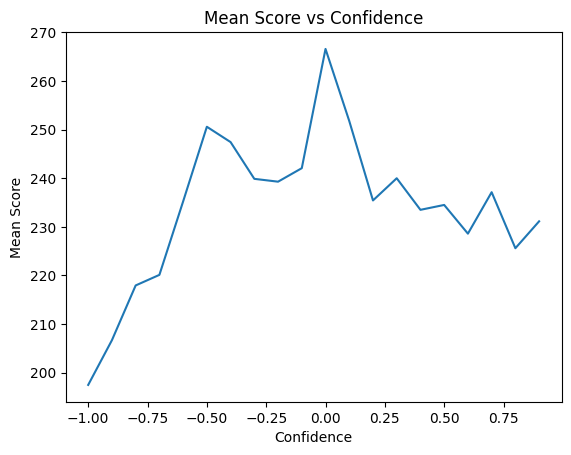

In [ ]:
from tqdm.notebook import tqdm
sweep = 20

range_multiple = 2

confidences = ((np.array(range(sweep))-sweep/2)/sweep)*range_multiple

scores = [np.array([run_episode("LunarLander-v3", 0.0, use_confidence=i) for _ in range(200)]).mean() for i in tqdm(confidences, desc="Confidence Sweep")]

plt.plot(confidences, scores)
plt.xlabel("Confidence")
plt.ylabel("Mean Score")
plt.title("Mean Score vs Confidence")
plt.show()